21.8 +/- 1.9
19.3 +/- 1.7


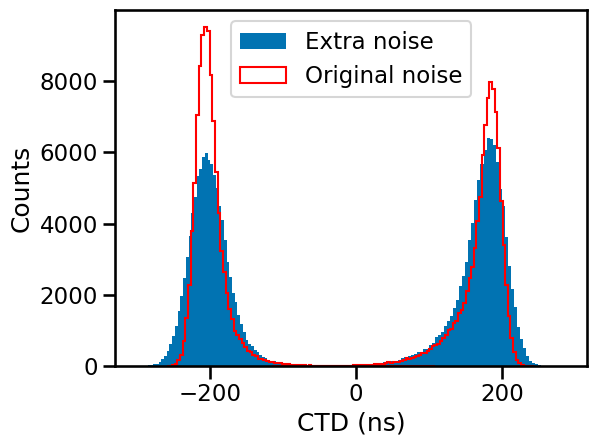

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

# Look at all Cs137 data prior to Loma Linda

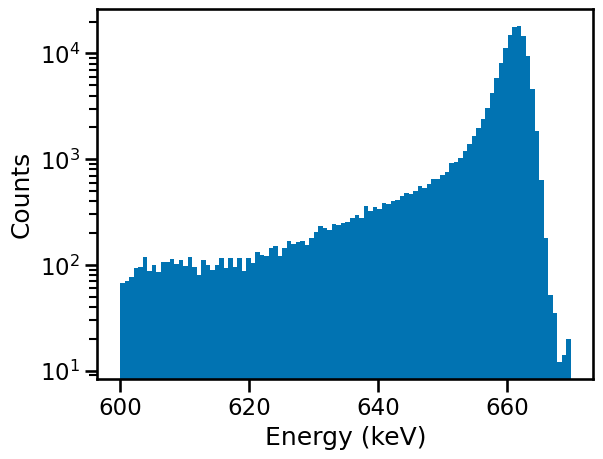

FWHM = 4.04
FWTM = 9.41


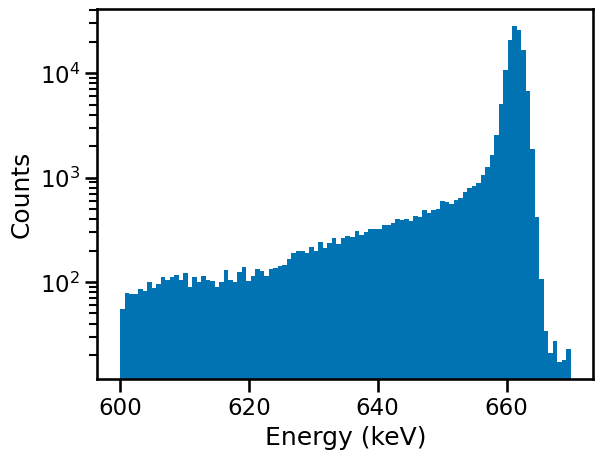

FWHM = 2.7
FWTM = 5.29


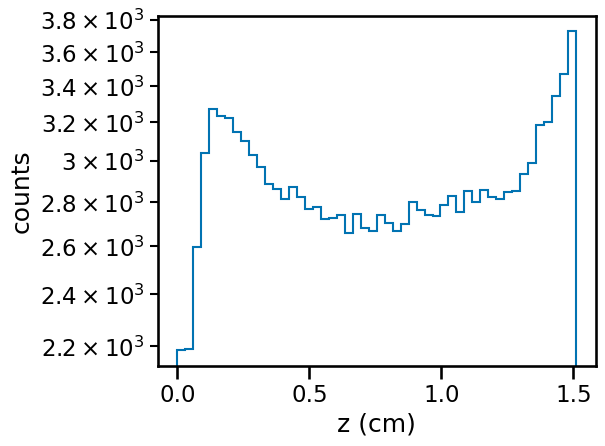

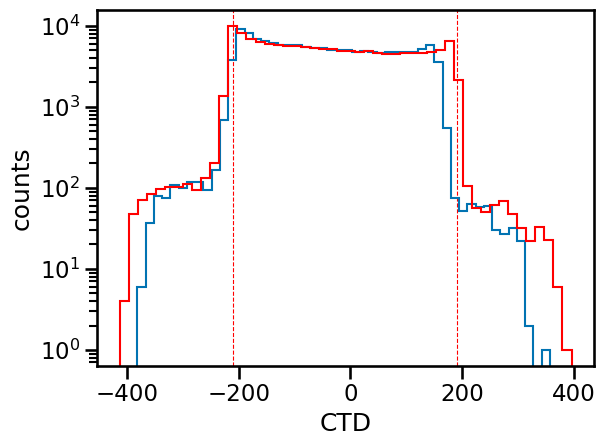

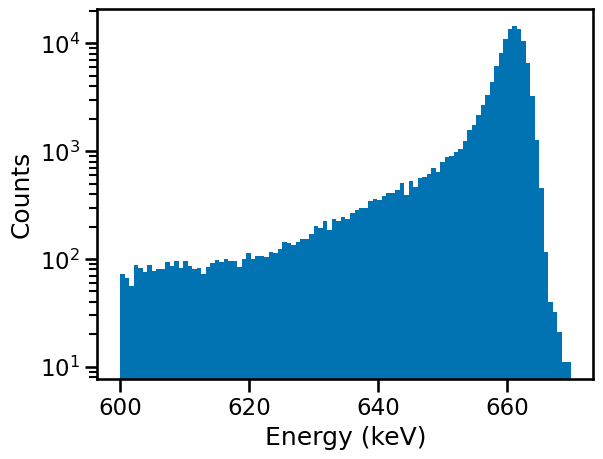

FWHM = 4.41
FWTM = 10.71


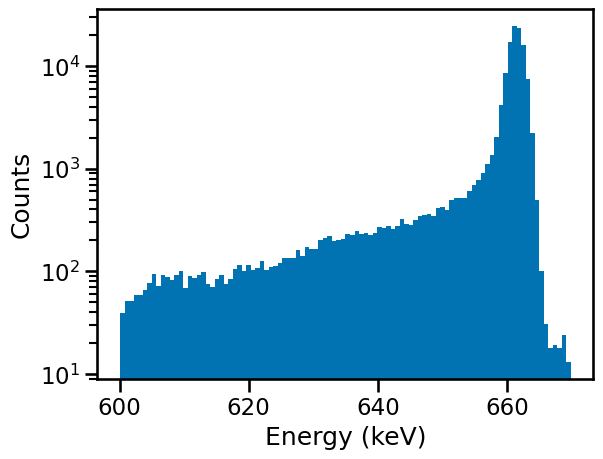

FWHM = 2.77
FWTM = 5.37


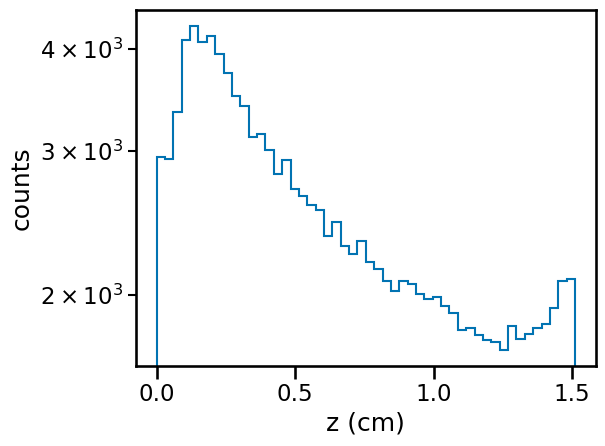

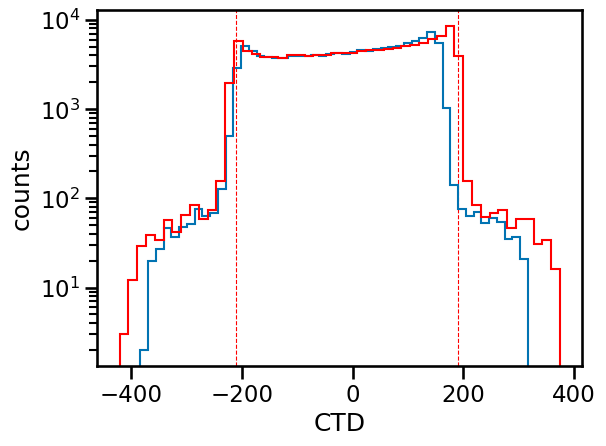

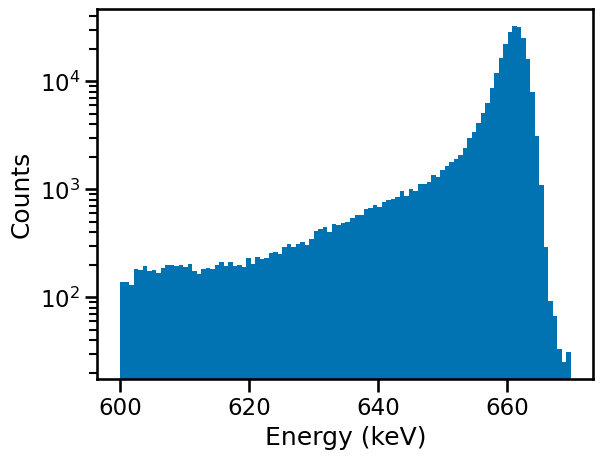

FWHM = 4.21
FWTM = 10.03


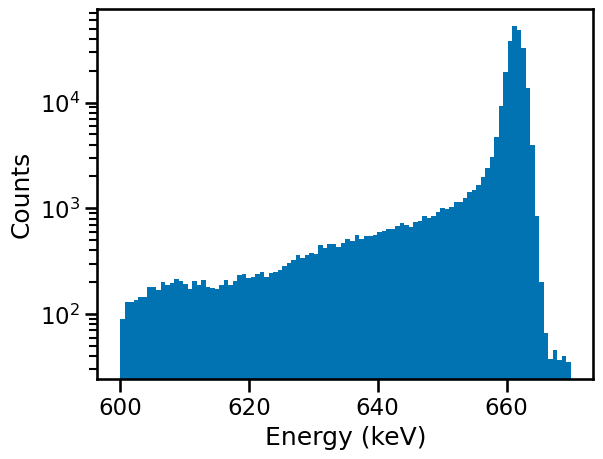

FWHM = 2.73
FWTM = 5.33


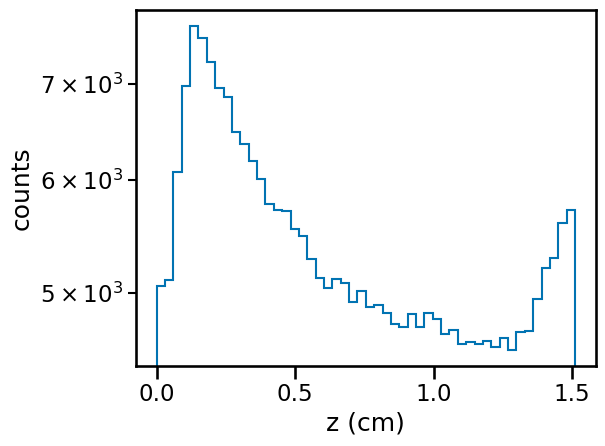

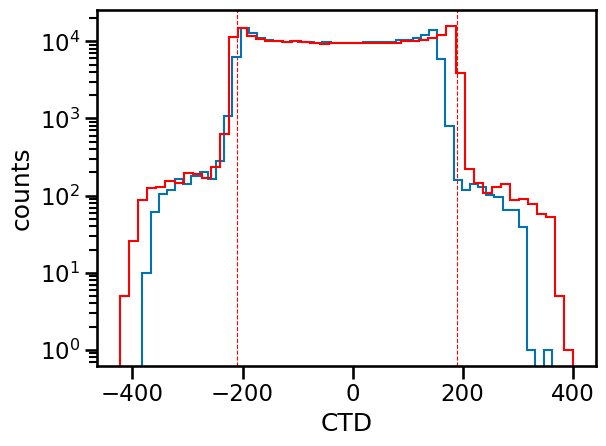

In [2]:
AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_preLL', 'allDC_preLL', 'allACandDC_preLL']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_preLL, h_signal_preLL = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [3]:
depth_correction(df_list[-1], z_list, e_signal_preLL, h_signal_preLL, plot_suffix = 'Cs137allACandDC_preLL')
print(e_signal_preLL)
print(h_signal_preLL)
# fit_CCE(z_list, e_signal_preLL, h_signal_preLL, sim_dCCE, plot_suffix = 'Cs137allACandDC_preLL')

FWHM = 4.21
FWTM = 10.03
FWHM = 3.57
FWTM = 8.38
FWHM = 2.73
FWTM = 5.33
FWHM = 2.7
FWTM = 5.22
[array([659.75735047, 659.72767639, 659.74999046, 659.89225373,
       660.10478059, 660.24379407, 660.24859646, 660.38570284,
       660.54868608, 660.62077634, 660.77092336, 660.83256343,
       660.95502474, 661.07454289, 661.14019573, 661.29027677,
       661.33310402, 661.4500516 , 661.52461617, 661.61539902,
       661.750052  , 661.8329973 , 661.94472914, 661.93631286,
       662.06279403, 662.13723795, 662.22325919, 662.31243759,
       662.30512025, 662.29558247]), array([0.05652908, 0.07472069, 0.04248153, 0.04069524, 0.03910349,
       0.03711451, 0.03779913, 0.03737384, 0.03339749, 0.03299619,
       0.03225823, 0.03077776, 0.02921217, 0.02733302, 0.0271677 ,
       0.0260915 , 0.02560203, 0.02427787, 0.02254171, 0.02247441,
       0.02102317, 0.02079074, 0.02068211, 0.01997551, 0.0190356 ,
       0.01865798, 0.01764516, 0.01711535, 0.01699836, 0.01639048])]
[array([661.62353681,

# Do the same for the data after LL round 1

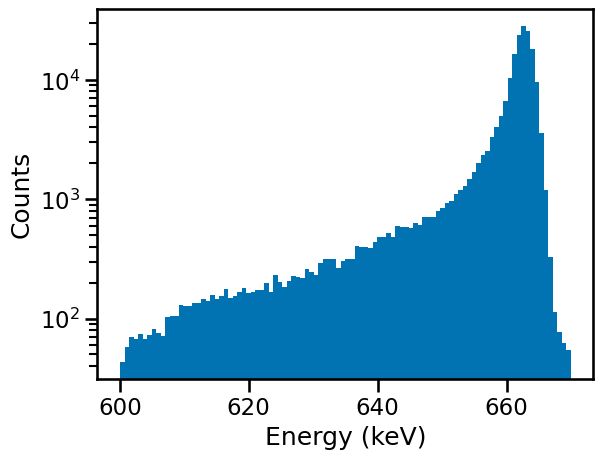

FWHM = 3.38
FWTM = 8.28


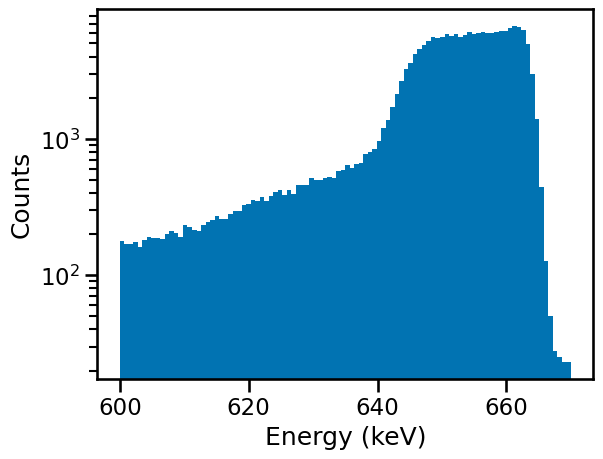

FWHM = 19.31
FWTM = 27.78


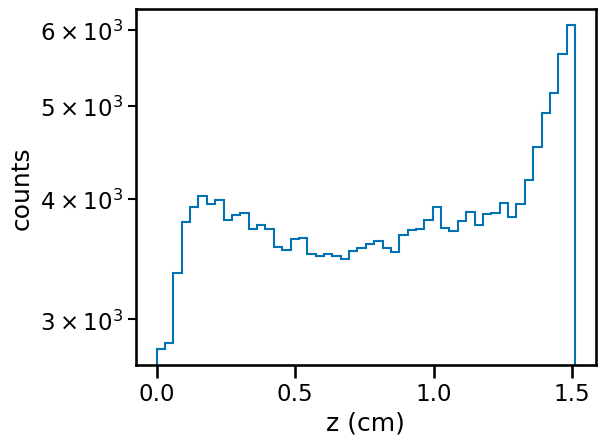

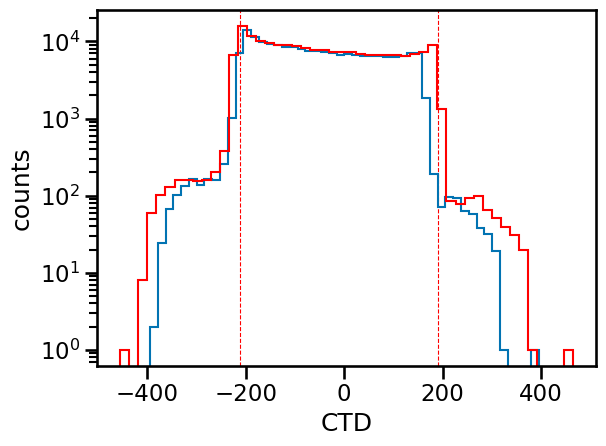

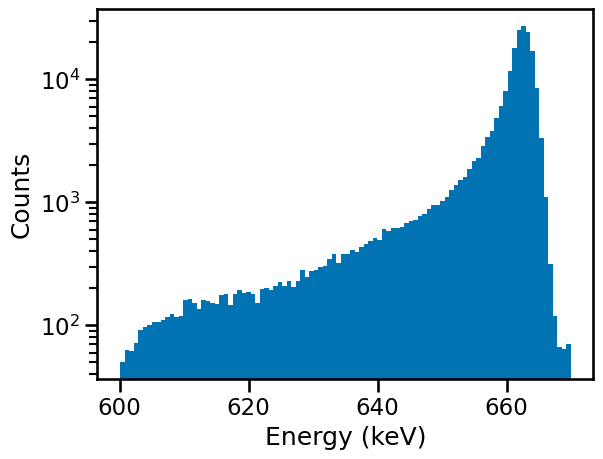

FWHM = 3.55
FWTM = 9.42


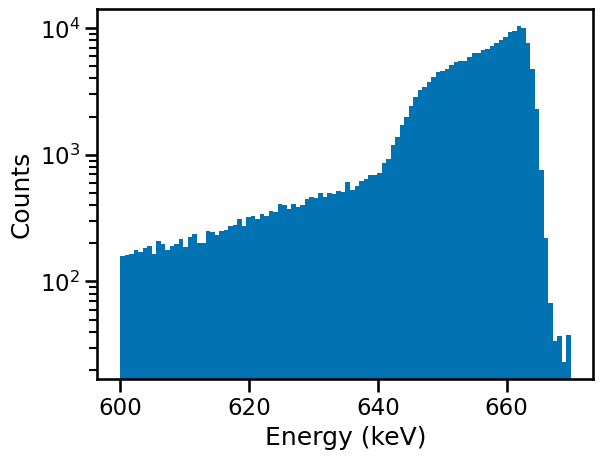

FWHM = 12.3
FWTM = 23.29


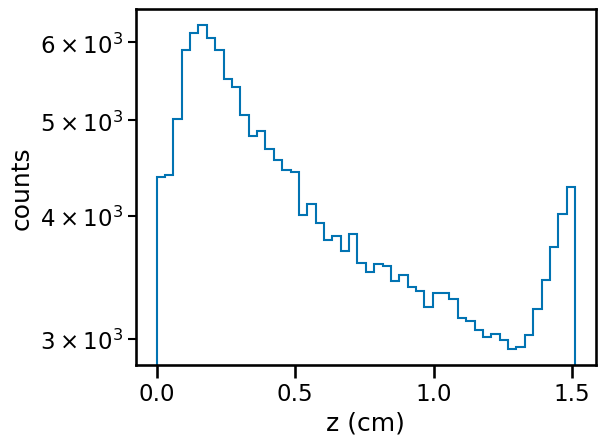

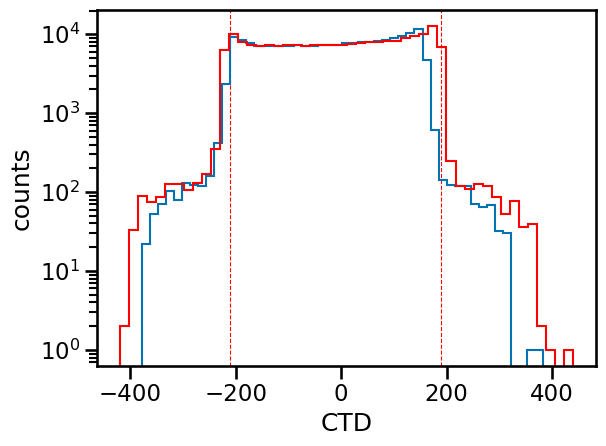

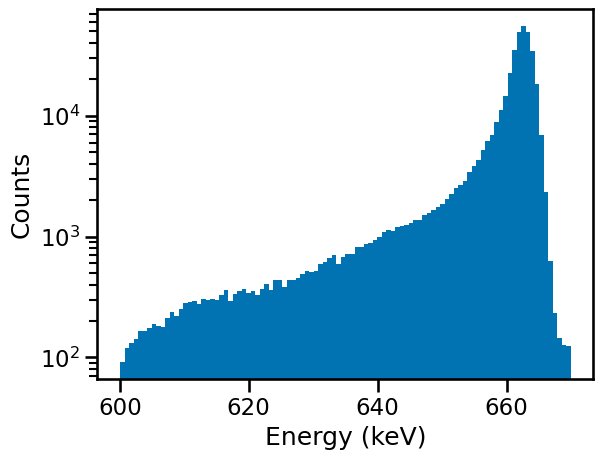

FWHM = 3.47
FWTM = 9.02


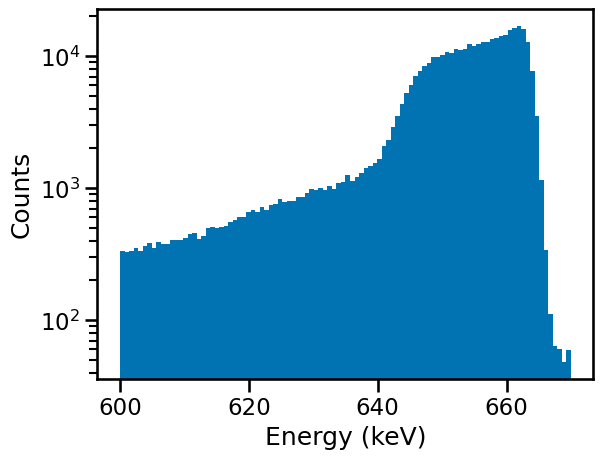

FWHM = 16.69
FWTM = 24.93


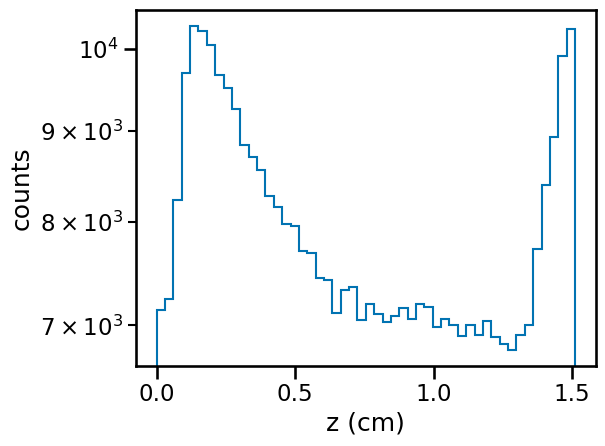

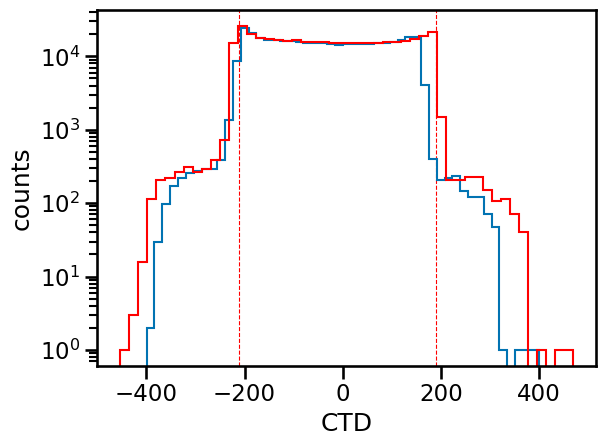

In [4]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL1', 'allDC_postLL1', 'allACandDC_postLL1']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [5]:
plt.figure()
plt.errorbar(z_list, e_signal_preLL[0], xerr = (z_list[1]-z_list[0])/2., yerr=e_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, e_signal_postLL1[0], xerr = (z_list[1]-z_list[0])/2., yerr=e_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=4)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'e_trapping_before_afterLL1.pdf')
plt.close()

plt.figure()
plt.errorbar(z_list, h_signal_preLL[0], xerr = (z_list[1]-z_list[0])/2., yerr=h_signal_preLL[1], fmt=".",label="undamaged")
plt.errorbar(z_list, h_signal_postLL1[0], xerr = (z_list[1]-z_list[0])/2., yerr=h_signal_postLL1[1],fmt=".",label="after first LL run")
plt.axhline(Cs_line, ls='--', color='C2')
plt.legend(loc=3)
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.5))
plt.tight_layout()
plt.savefig(plot_dir + 'hole_trapping_before_afterLL1.pdf')
plt.close()


In [6]:
depth_correction(df_list[-1], z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'Cs137allACandDC_postLL1')
# fit_CCE(z_list, e_signal_postLL1, h_signal_postLL1, sim_dCCE, plot_suffix = 'Cs137allACandDC_postLL1')

FWHM = 3.47
FWTM = 9.02
FWHM = 3.34
FWTM = 8.5
FWHM = 16.69
FWTM = 24.93
FWHM = 3.89
FWTM = 9.21


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,5,11,29,634.707619,165.0,30,651.024903,270.0,1.634266e+307,1.634266e+307,1.006803,0.046301,"(1.007, 1.057]",633.257278,660.441410
1,226,11,26,645.811275,195.0,31,658.296893,185.0,1.634266e+307,1.634266e+307,0.526416,0.039074,"(0.503, 0.554]",644.841540,661.585254
2,237,11,29,661.685139,210.0,21,655.784919,140.0,1.634266e+307,1.634266e+307,0.358021,0.035775,"(0.352, 0.403]",661.028688,657.201073
3,242,11,36,663.903327,195.0,22,656.770645,185.0,1.634266e+307,1.634266e+307,0.520614,0.039347,"(0.503, 0.554]",662.917268,659.984244
4,267,11,3,658.637600,140.0,22,651.787015,335.0,1.634266e+307,1.634266e+307,1.327963,0.064481,"(1.309, 1.359]",657.441144,665.958008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394380,2839868,11,12,659.342959,205.0,30,657.088104,160.0,1.634266e+307,1.634266e+307,0.348566,0.036251,"(0.302, 0.352]",658.708794,658.407888
394381,2839958,11,12,663.975611,195.0,14,653.446032,190.0,1.634266e+307,1.634266e+307,0.574702,0.038770,"(0.554, 0.604]",662.891261,657.273991
394382,2839997,11,12,668.608434,170.0,28,652.442836,270.0,1.634266e+307,1.634266e+307,0.950932,0.044771,"(0.906, 0.956]",667.090959,661.099837
394383,2840195,11,12,610.711589,195.0,13,654.640664,190.0,1.634266e+307,1.634266e+307,0.507338,0.038968,"(0.503, 0.554]",609.827596,657.691487


# Same for after LL round 2

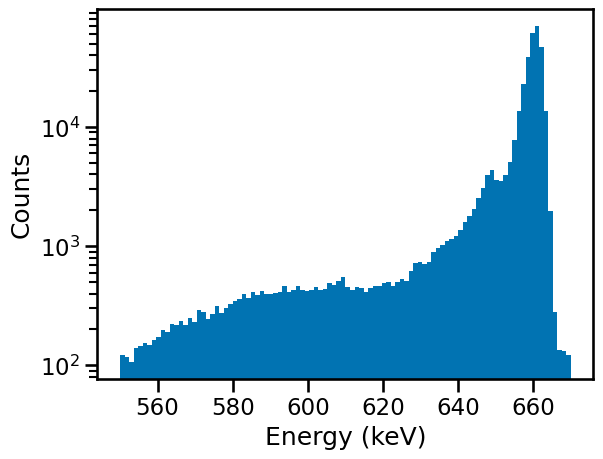

FWHM = 4.22
FWTM = 9.09


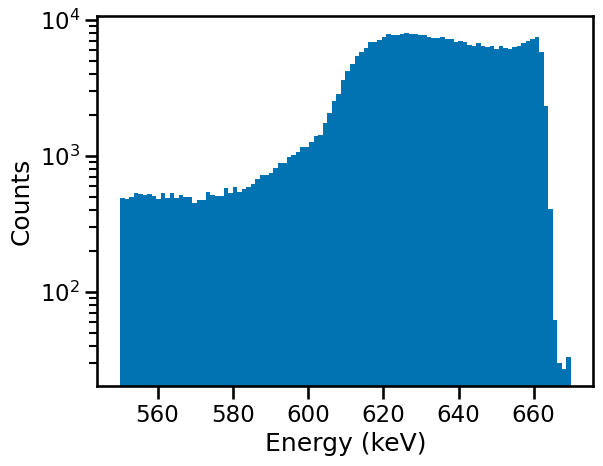

FWHM = 52.68
FWTM = 72.95


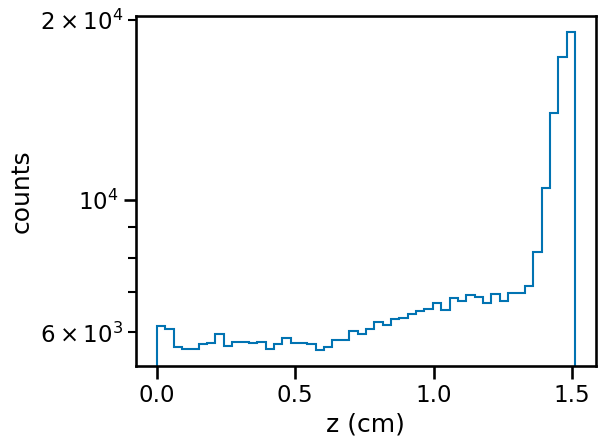

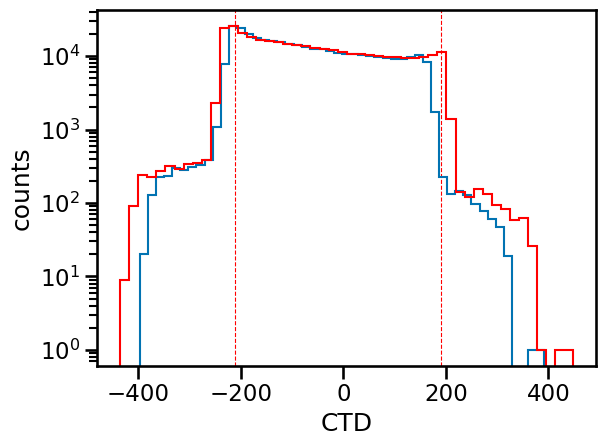

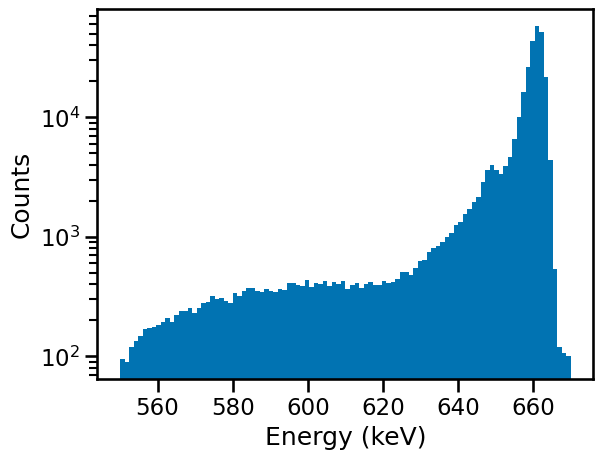

FWHM = 4.32
FWTM = 9.84


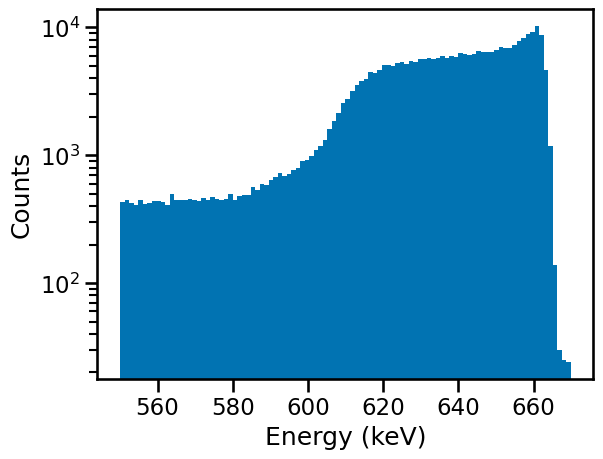

FWHM = 42.65
FWTM = 63.27


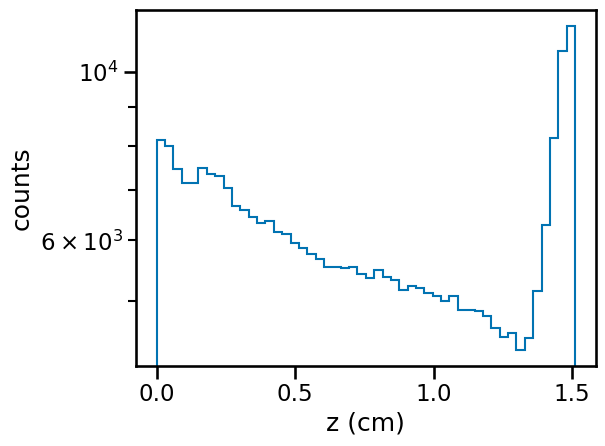

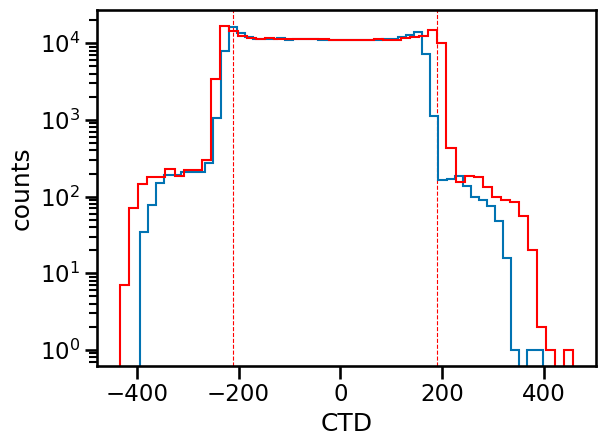

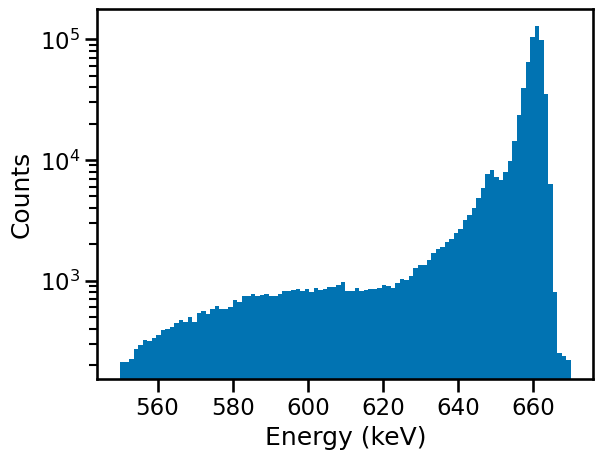

FWHM = 4.28
FWTM = 9.47


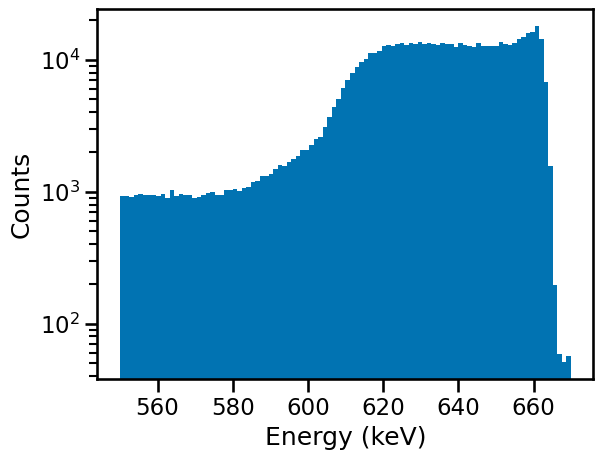

FWHM = 49.91
FWTM = 68.06


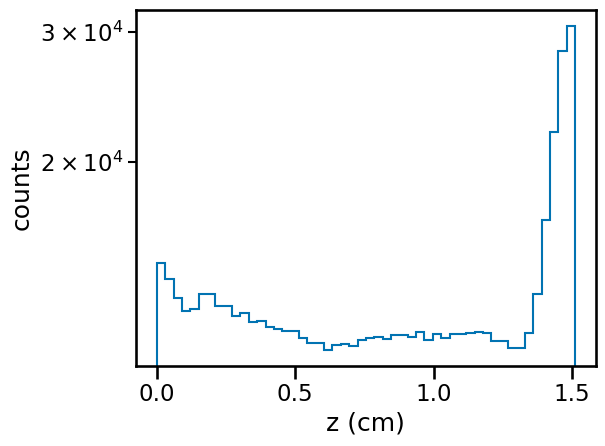

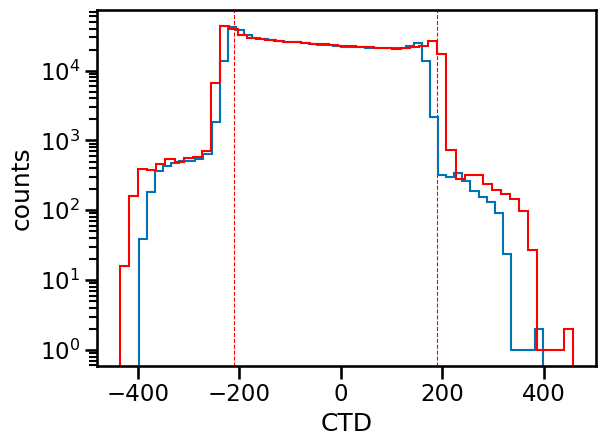

In [7]:
AC_list = ['20231120_Cs137_AC_600V.dat', '20231205_Cs137_AC_600V.dat', '20231208_Cs137_AC_600V.dat', '20231127_Cs137_AC_600V.dat', '20231206_Cs137_AC_600V.dat', '20231204_Cs137_AC_600V.dat', '20231207_Cs137_AC_600V.dat']
DC_list = ['20231122_Cs137_DC_600V.dat', '20231129_Cs137_DC_600V.dat', '20231201_Cs137_DC_600V.dat', '20231128_Cs137_DC_600V.dat', '20231130_Cs137_DC_600V.dat', '20231215_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL2', 'allDC_postLL2', 'allACandDC_postLL2']

emin = 550.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL2/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL2, h_signal_postLL2 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [8]:
depth_correction(df_list[-1], z_list, e_signal_postLL2, h_signal_postLL2, plot_suffix = 'Cs137allACandDC_postLL2')
# fit_CCE(z_list, e_signal_postLL2, h_signal_postLL2, sim_dCCE, plot_suffix = 'Cs137allACandDC_postLL2)

FWHM = 4.28
FWTM = 9.47
FWHM = 3.81
FWTM = 8.44
FWHM = 49.91
FWTM = 68.06
FWHM = 6.83
FWTM = 28.66


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,61,11,22,661.388388,150.0,28,628.711191,275.0,1.634266e+307,1.634266e+307,1.056716,0.046642,"(1.007, 1.057]",661.702193,665.711529
1,168,11,2,591.212232,185.0,9,580.030877,190.0,1.634266e+307,1.634266e+307,0.602334,0.040728,"(0.554, 0.604]",591.278440,595.522134
2,171,11,19,660.964171,165.0,28,624.604303,300.0,1.634266e+307,1.634266e+307,1.181870,0.047180,"(1.158, 1.208]",661.739475,668.518331
3,251,11,10,658.332789,240.0,25,654.350661,155.0,1.634266e+307,1.634266e+307,0.236027,0.033712,"(0.201, 0.252]",659.069063,659.515046
4,332,11,37,661.499646,220.0,20,651.214799,155.0,1.634266e+307,1.634266e+307,0.313096,0.035215,"(0.302, 0.352]",662.081114,658.709051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649925,4172506,11,6,657.863801,150.0,9,624.415785,370.0,1.634266e+307,1.634266e+307,1.454007,0.043535,"(1.409, 1.46]",660.479846,687.253752
649926,4172658,11,30,661.371904,235.0,34,655.766519,170.0,1.634266e+307,1.634266e+307,0.290172,0.034665,"(0.252, 0.302]",662.000397,662.597886
649927,4172683,11,25,660.438183,165.0,22,615.010424,355.0,1.634266e+307,1.634266e+307,1.495634,0.059080,"(1.46, 1.51]",663.466914,680.229721
649928,4172713,11,35,663.613850,160.0,8,636.828702,270.0,1.634266e+307,1.634266e+307,1.016556,0.045876,"(1.007, 1.057]",663.823999,672.144013


# After room temp anneal

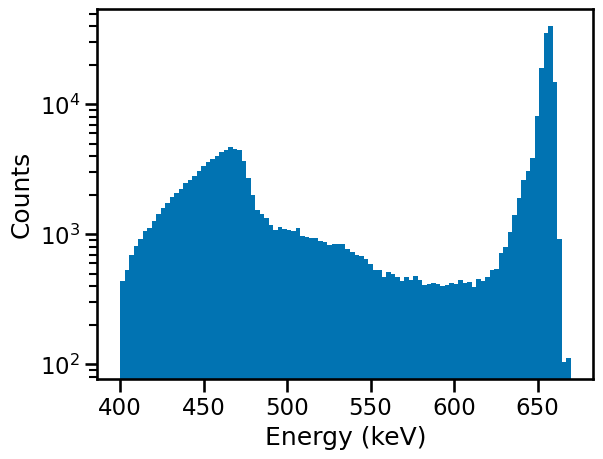

FWHM = 7.42
FWTM = 204.64


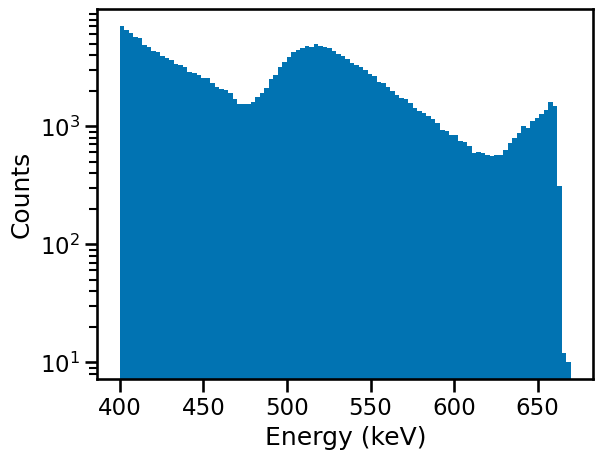

FWHM = 106.29
FWTM = 53.84


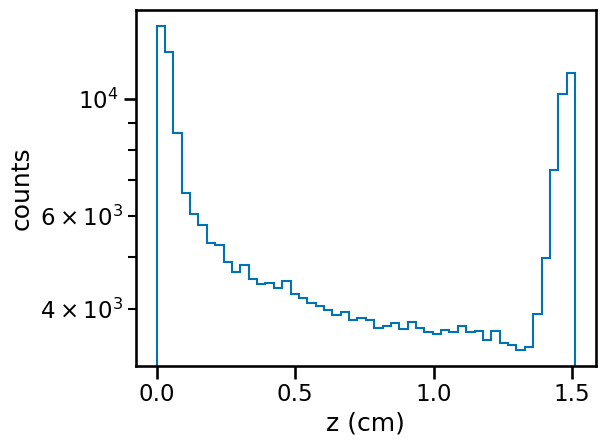

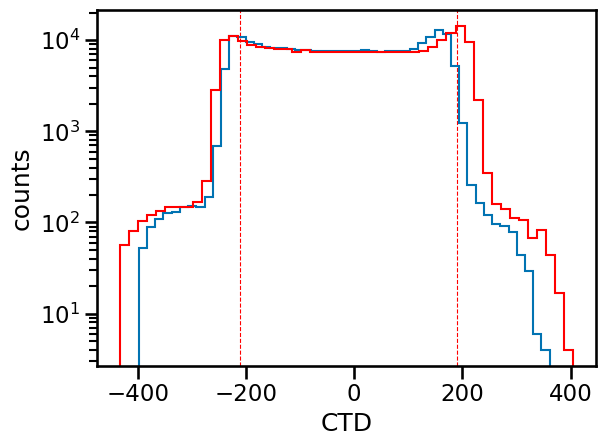

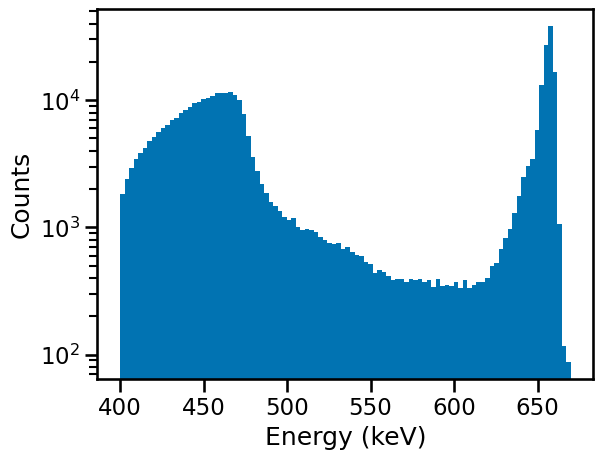

FWHM = 6.54
FWTM = 250.66


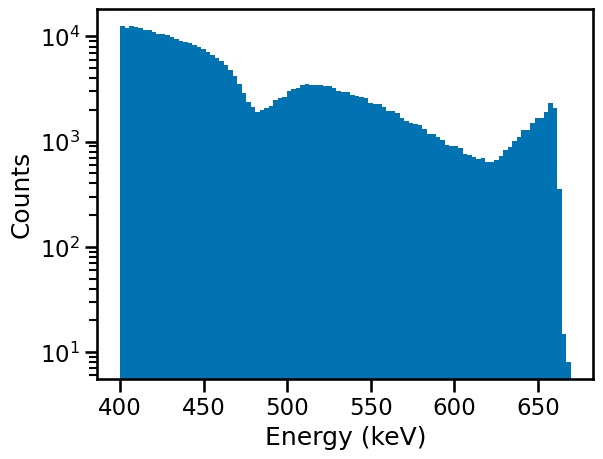

FWHM = 0.0
FWTM = 78.39


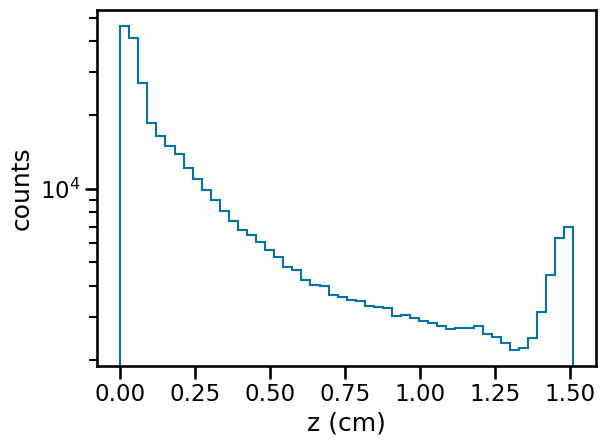

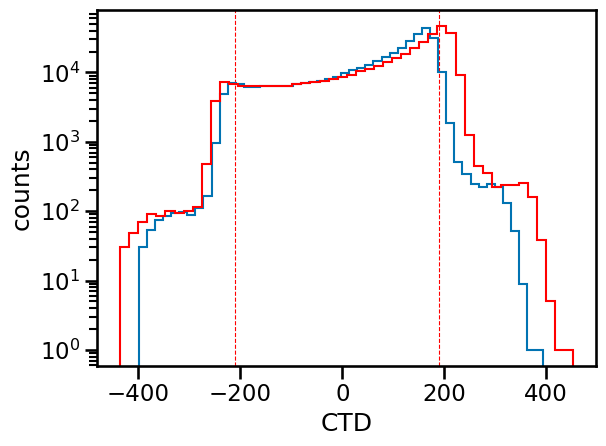

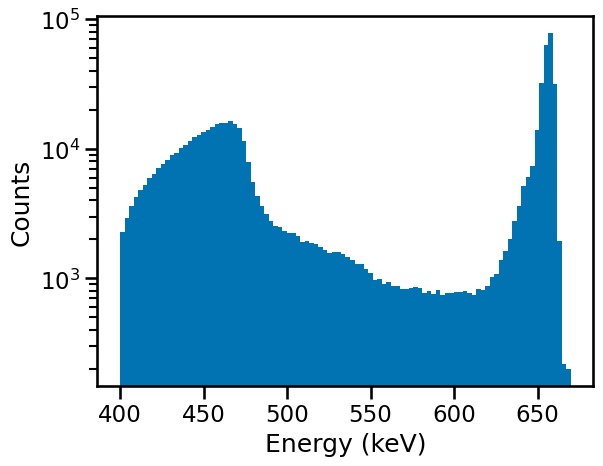

FWHM = 7.03
FWTM = 235.53


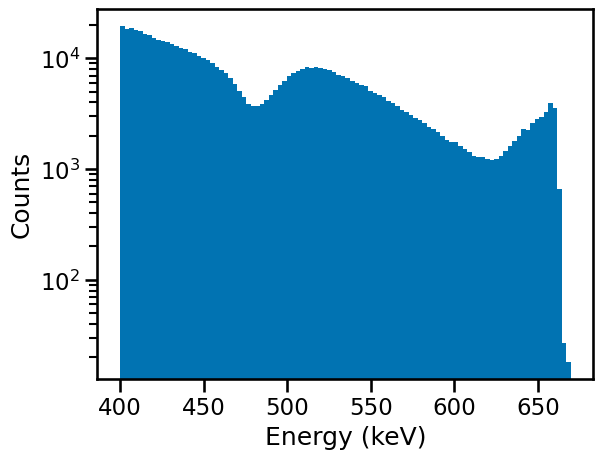

FWHM = 0.0
FWTM = 68.66


In [ ]:
AC_list = ['20240117_Cs137_AC_600V.dat', '20240122_Cs137_AC_600V.dat', '20240119_Cs137_AC_600V.dat', '20240123_Cs137_AC_600V.dat']
DC_list = ['20240124_Cs137_DC_600V.dat', '20240125_Cs137_DC_600V.dat', '20240126_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postroomtemp', 'allDC_postroomtemp', 'allACandDC_postroomtemp']

emin = 400.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postroomtemp/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postroomtemp, h_signal_postroomtemp = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax, num_z = 15)

In [ ]:
depth_correction(df_list[-1], z_list, e_signal_postroomtemp, h_signal_postroomtemp, plot_suffix = 'Cs137allACandDC_postroomtemp')
# fit_CCE(z_list, e_signal_postroomtemp, h_signal_postroomtemp, sim_dCCE, plot_suffix = 'Cs137allACandDC_postroomtemp')